In [ ]:
# Install required libraries, uncomment if needed
%pip install git+https://github.com/opendifferentialprivacy/smartnoise-sdk#subdirectory=sdk
%pip install faker zipcodes tqdm opendp-smartnoise
!pip install z3-solver==4.8.9.0

  Cloning https://github.com/opendifferentialprivacy/smartnoise-sdk to /tmp/pip-req-build-9npzxa76
  Running command git clone --filter=blob:none --quiet https://github.com/opendifferentialprivacy/smartnoise-sdk /tmp/pip-req-build-9npzxa76
  Encountered 3 file(s) that should have been pointers, but weren't:
        datasets/PUMS_large.csv
        datasets/askreddit.csv.zip
        datasets/clean_askreddit.csv
  Resolved https://github.com/opendifferentialprivacy/smartnoise-sdk to commit a1d5b47d6e42cfec9d99f40f5860e7ed8943c2e7
ERROR: git+https://github.com/opendifferentialprivacy/smartnoise-sdk#subdirectory=sdk does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.6/719.6 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.8/193.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.

In [ ]:
!pip install reindent


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import pandas as pd
import numpy as np
import random
import string
import uuid
import time
import logging
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import reident_tools as reident
from opendp.smartnoise.synthesizers.mwem import MWEMSynthesizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


## Import data sets
Below, we are going to import three data sets:
1. Public medical data set, containing k-anonymized demographic and sensitive medical information
2. Attacker's data collection with basic demographic information
3. Public medical data set preprocessed for the MWEM synthesizer

In [ ]:
# Read files
df_medical = pd.read_csv('/content/data_medical.csv', sep=",", encoding="utf-8").infer_objects()
df_medical['Zip'] = df_medical['Zip'].astype(str)
print('Anonymized dataset including sensitive medical information:')
display(df_medical.iloc[:,1:].sample(8))
df_demographic = pd.read_csv('/content/data_demographic.csv', sep=",", encoding="utf-8").infer_objects()
print('Attacker`s data collection with basic demographic information:')
df_demographic['Zip'] = df_demographic['Zip'].astype(str)
display(df_demographic.iloc[:,1:].sample(8))
df_medical_synth = pd.read_csv('/content/data_medical_synthesizer.csv', sep=",", encoding="utf-8").infer_objects()
df_medical_synth['Zip'] = df_medical_synth['Zip'].astype(str)

Anonymized dataset including sensitive medical information:


,Gender,Age,Zip,Diagnosis,Treatment,Outcome
13530,M,40-49,276**,Depression,42,intensive care
3243,M,30-39,121**,Alzheimer,20,unchanged
16351,F,70-79,377**,Heart Disease,27,recovered
1343,F,10-19,422**,Alzheimer,38,intensive care
13435,F,50-59,714**,Diabetes,35,intensive care
773,F,20-29,359**,High Blood Pressure,44,recovered
28381,M,60-69,470**,Depression,34,intensive care
9726,F,50-59,254**,Alzheimer,20,recovered


Attacker`s data collection with basic demographic information:


,Name,Gender,Age,Zip
15572,Michael Ward,M,11,26089
19467,Timothy Torres,M,74,8420
6051,Mrs. Vicki Mayo MD,F,23,11073
24164,Lindsey Middleton,F,71,77497
1595,Tina Taylor,F,36,29394
10091,Dana Parsons,F,13,73363
29039,Lisa Wilson,F,83,41615
9214,Joseph Hardy,M,85,28396


In [ ]:
df_demographic.shape

(30000, 5)

In [ ]:
df_medical.shape

(30000, 7)

In [ ]:
df_medical_synth.shape

(30000, 7)

Above data sets also include a unique id for each record which is used to be able to count the number of identified records after the attack. This information is not used for performing the attack.

### Perform the attack
Now, we perform the reidentification attack with the demographic and the medical data set, using a combinatorial approach.

In [ ]:
%%time
reident_attack = reident.try_reidentification(df_demographic, df_medical, logger)

INFO:root:Performing reidentification with anonymized data: 30000. Attacker collection: 30000
100%|██████████| 30000/30000 [08:00<00:00, 62.37it/s]
INFO:root:Identified 28962 potential matches!
INFO:root:Validating IDs ...
100%|██████████| 28962/28962 [00:01<00:00, 16270.78it/s]
INFO:root:Identified 9071 actual (validated) matches!


CPU times: user 7min 56s, sys: 2.5 s, total: 7min 59s
Wall time: 8min 2s


### Results of the attack
Below, we show the amount of potential and actual matches and provide a glance at the data.

In [ ]:
print(f'Found: {len(reident_attack[reident_attack["ID_Match"]==True])} actual (validated) matches!')

Found: 9008 actual (validated) matches!


In [ ]:
# Write to file, if wanted
# reident_attack.to_csv('data/results_reident-attack-raw.csv', sep=",", encoding="utf-8", index=False)
# Or read files, if needed
# reident_attack = pd.read_csv('data/results_reident-attack-raw.csv', sep=",", encoding="utf-8")

In [ ]:
# Get sample from the data set
print(f'Sample of re-identified patients:')
reident_attack[reident_attack["ID_Match"]==True][['Name', 'Gender', 'Age', 'Zip', 'Diagnosis', 'Treatment', 'Outcome', 'ID_Match']].sample(10)

Sample of re-identified patients:


,Name,Gender,Age,Zip,Diagnosis,Treatment,Outcome,ID_Match
18435,John Glass,M,13,14192,High Blood Pressure,42,unchanged,True
28428,Kenneth Kelly,M,51,59827,High Blood Pressure,21,intensive care,True
4646,Renee Jones,F,45,72635,Osteoporosis,20,recovered,True
11652,Joseph Garcia,M,22,28634,Heart Disease,31,recovered,True
20958,Alicia Nelson,F,80,31760,Alzheimer,20,recovered,True
3450,Elizabeth Lewis,F,62,15393,Alzheimer,35,intensive care,True
10122,Joseph Garcia,M,54,96841,Alzheimer,45,recovered,True
17191,Nicole Owen,F,40,90937,Stroke,37,unchanged,True
16165,Courtney Kim,F,50,25757,Alzheimer,41,intensive care,True
5976,Jerry Kelly,M,49,38285,Depression,31,intensive care,True


## Protecting the medical dataset with differential privacy
In the next step, we are going to synthesize the data set to increase the level of protection. We will use the Multiple Weights Exponential Mechanism (MWEM) synthesizer for this purpose and encode the demographic data (gender, age, zip) and the diagnosis. The other variables (treatment, outcome) are not part of the analysis for now.

In [ ]:
# Prepare data set for reidentification, using the medical data set and the full zip copied from the demographic set
df_reident_synth = df_medical[['Gender', 'Age', 'Zip', 'Diagnosis', 'Treatment', 'Outcome']].copy()
df_reident_synth['Zip'] = df_demographic['Zip'].copy()
df_reident_synth['Age'] = df_demographic['Age'].copy()
# Write to file, if wanted
# df_reident_synth.to_csv('data/data_reidentification_synthesizer.csv', sep=",", encoding="utf-8", index=False)

### Encoding of data
For this purpose, we encode the input data using the `do_encode`-function to make it compatible with the MWEM synthesizer.

In [ ]:
# Have a quick glance at the data
df_reident_synth.head()

,Gender,Age,Zip,Diagnosis,Treatment,Outcome
0,F,10,65418,High Blood Pressure,25,intensive care
1,F,14,65475,COPD,48,unchanged
2,F,10,65484,High Blood Pressure,38,intensive care
3,F,30,27727,Heart Disease,31,unchanged
4,F,36,27772,Diabetes,34,unchanged


In [ ]:
# Encode the data set and display it
df_reident_encoded = reident.do_encode(df_reident_synth, ['Gender', 'Age', 'Zip', 'Diagnosis'], reident.diseases)
df_reident_encoded.head()

,Gender_encoded,Age_encoded,Zip_encoded,Diagnosis_encoded
0,0,10,65418,9
1,0,14,65475,2
2,0,10,65484,9
3,0,30,27727,7
4,0,36,27772,3


In [ ]:
%%time
# Apply the synthesizer to the data set
synthetic_data = MWEMSynthesizer(q_count = 400,
                        epsilon = 3.00,
                        iterations = 60,
                        mult_weights_iterations = 40,
                        splits = [],
                        split_factor = 1)
synthetic_data.fit(df_reident_encoded.to_numpy())

CPU times: user 10.4 s, sys: 135 ms, total: 10.5 s
Wall time: 14 s


In [ ]:
%%time
# Convert to dataframe
df_synthesized = pd.DataFrame(synthetic_data.sample(int(df_reident_encoded.shape[0])), columns=df_reident_encoded.columns)

CPU times: user 3.26 s, sys: 154 ms, total: 3.42 s
Wall time: 3.35 s


In [ ]:
print(df_synthesized.columns)


Index(['Gender_encoded', 'Age_encoded', 'Zip_encoded', 'Diagnosis_encoded'], dtype='object')


In [ ]:
df=df_medical_synth.copy()

In [ ]:
df_synthesized.head()

,Gender_encoded,Age_encoded,Zip_encoded,Diagnosis_encoded
0,0,25,51646,4
1,1,61,50452,9
2,0,46,84875,4
3,0,24,17223,8
4,0,88,29958,7


In [ ]:
df.head()

,ID,Gender,Age,Zip,Diagnosis,Treatment,Outcome
0,92100f5c41aa4ce79c78277a592a79eb,F,10,65418,High Blood Pressure,25,intensive care
1,082a308d47aa4a3f9f56ba4d01f9c271,F,14,65475,COPD,48,unchanged
2,a41da7769de940eb883502d1bee5063e,F,10,65484,High Blood Pressure,38,intensive care
3,c45624ac3f3e4d4a8975106ace83dcf8,F,30,27727,Heart Disease,31,unchanged
4,997c2c22f24b472e90761a55e9186627,F,36,27772,Diabetes,34,unchanged


In [ ]:
df = df.drop(columns=['Outcome', 'Treatment', 'ID'])

In [ ]:
df.head()

,Gender,Age,Zip,Diagnosis
0,F,10,65418,High Blood Pressure
1,F,14,65475,COPD
2,F,10,65484,High Blood Pressure
3,F,30,27727,Heart Disease
4,F,36,27772,Diabetes


In [ ]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df['Diagnosis']= label_encoder.fit_transform(df['Diagnosis'])

df['Diagnosis'].unique()

array([7, 2, 6, 5, 1, 8, 4, 3, 0, 9])

In [ ]:
df['Gender']= label_encoder.fit_transform(df['Gender'])

df['Gender'].unique()

array([0, 1])

In [ ]:
df_synthesized['Zip_encoded'].unique()

array([51646, 50452, 84875, 17223, 29958, 60401, 36723, 75523, 36126,
       99202, 20009, 67962, 72937, 23591, 83880, 76120, 41897, 67166,
       40902,  8469, 57815, 69554, 20208, 49060, 12448, 67365, 22994,
       39708, 94824, 17621, 77115, 76319, 84676,  3693, 28565, 90049,
       55029, 11453,  4290, 82090, 74728, 15632, 45279, 17422, 21402,
       51447, 17820, 27371,  8071, 43488, 26774, 94625, 33341, 62590,
       16229, 31948, 27968, 76916, 35728, 42493, 62789, 97809, 25978,
       58014, 53437,  2897, 59008, 83085,   907, 96018, 52044, 52243,
       89253, 99003, 87263, 80498, 50055, 49856, 12647, 16627, 48861,
       26575,  7076, 27570, 60998, 40703, 68559, 69952, 52840, 55825,
       12249, 22198, 21203, 63784,  4091,  6877, 35330, 72738, 61993,
        7275, 70748, 44284, 42294, 23392, 37121,  3096, 45080, 47866,
       35131, 88457, 58213, 72340, 23193, 37519, 97212, 48662,  3494,
       65973, 62192, 29162, 51248, 70151, 95023, 67564, 69156, 80100,
       27172, 75126,

In [ ]:
df['Zip'].unique()

array(['65418', '65475', '65484', ..., '91680', '15189', '15124'],
      dtype=object)

In [ ]:
df['Zip']= label_encoder.fit_transform(df['Zip'])

df['Zip'].unique()

array([15767, 15779, 15783, ..., 23159,  1470,  1454])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(df, df_synthesized)
mean_cosine_similarity = similarity_matrix.mean()
print(f"Mean Cosine Similarity: {mean_cosine_similarity}")

Mean Cosine Similarity: 0.9980119350705348


In [ ]:
# Assuming 'Diagnosis' is the target variable
target_column = 'Diagnosis_encoded'

In [ ]:
# Step 1: Supervised Learning for Synthesis
# Assuming 'Diagnosis' is the target variable
X_synthesis = df_synthesized.drop(columns=[target_column])
y_synthesis = df_synthesized[target_column]

In [ ]:
y_synthesis.head()

0    4
1    9
2    4
3    8
4    7
Name: Diagnosis_encoded, dtype: int64

In [ ]:
# Step 1: Supervised Learning for Synthesis
# Train a RandomForestRegressor
synthesis_model = RandomForestRegressor()
synthesis_model.fit(X_synthesis, y_synthesis)

RandomForestRegressor()

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

synthetic_data_ml = synthesis_model.predict(X_synthesis)
mae = mean_absolute_error(y_synthesis, synthetic_data_ml)
print(f"Mean Absolute Error: {mae}")
mse = mean_squared_error(y_synthesis, synthetic_data_ml)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_synthesis, synthetic_data_ml)
print(f"R-squared: {r2}")

Mean Absolute Error: 1.1739114689238863
Mean Squared Error: 2.2649910990179225
R-squared: 0.6727067208985873


In [ ]:
# Generate synthetic data
synthetic_data_ml = synthesis_model.predict(X_synthesis)

In [ ]:
# Step 2: Unsupervised Learning for Re-identification Analysis
# Combine demographic and synthetic data for clustering
df_combined = pd.concat([df_demographic, pd.DataFrame(synthetic_data_ml, columns=['Diagnosis_synthetic'])], ignore_index=True)

In [ ]:
# List of non-numeric columns to exclude from clustering
non_numeric_columns = ['ID', 'Name']

# Select only numeric columns for clustering
numeric_columns = df_combined.select_dtypes(include=['number']).columns
numeric_columns = [col for col in numeric_columns if col not in non_numeric_columns]

from sklearn.impute import SimpleImputer

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
df_combined[numeric_columns] = imputer.fit_transform(df_combined[numeric_columns])

# Fit a KMeans clustering model
cluster_model = KMeans(n_clusters=2, random_state=42)
cluster_labels = cluster_model.fit_predict(df_combined[numeric_columns])



In [ ]:
# Add cluster labels to the demographic and synthetic data
df_demographic['Cluster'] = cluster_labels[:len(df_demographic)]
df_synthesized['Cluster'] = cluster_labels[len(df_demographic):]

In [ ]:
print(df_synthesized.columns)

Index(['Gender_encoded', 'Age_encoded', 'Zip_encoded', 'Diagnosis_encoded',
       'Cluster'],
      dtype='object')


In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(df_combined[numeric_columns], cluster_labels)

print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6382625741825069


For original data

In [ ]:
# Assuming 'Diagnosis' is the target variable
target_column = 'Diagnosis'

In [ ]:
# Step 1: Supervised Learning for Synthesis
# Assuming 'Diagnosis' is the target variable
X_synthesis = df.drop(columns=[target_column])
y_synthesis = df[target_column]

In [ ]:
y_synthesis.head()

0    7
1    2
2    7
3    6
4    5
Name: Diagnosis, dtype: int64

In [ ]:
# Step 1: Supervised Learning for Synthesis
# Train a RandomForestRegressor
synthesis_model = RandomForestRegressor()
synthesis_model.fit(X_synthesis, y_synthesis)

RandomForestRegressor()

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

synthetic_data_ml = synthesis_model.predict(X_synthesis)
mae = mean_absolute_error(y_synthesis, synthetic_data_ml)
print(f"Mean Absolute Error: {mae}")
mse = mean_squared_error(y_synthesis, synthetic_data_ml)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_synthesis, synthetic_data_ml)
print(f"R-squared: {r2}")

Mean Absolute Error: 0.9727992706349207
Mean Squared Error: 1.3375283177833064
R-squared: 0.830737526026565


In [ ]:
# Generate synthetic data
synthetic_data_ml = synthesis_model.predict(X_synthesis)

In [ ]:
# Step 2: Unsupervised Learning for Re-identification Analysis
# Combine demographic and synthetic data for clustering
df_combined = pd.concat([df, pd.DataFrame(synthetic_data_ml, columns=['Diagnosis'])], ignore_index=True)

In [ ]:
# List of non-numeric columns to exclude from clustering
non_numeric_columns = ['ID', 'Name']

# Select only numeric columns for clustering
numeric_columns = df_combined.select_dtypes(include=['number']).columns
numeric_columns = [col for col in numeric_columns if col not in non_numeric_columns]

from sklearn.impute import SimpleImputer

# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
df_combined[numeric_columns] = imputer.fit_transform(df_combined[numeric_columns])

# Fit a KMeans clustering model
cluster_model = KMeans(n_clusters=2, random_state=42)
cluster_labels = cluster_model.fit_predict(df_combined[numeric_columns])



In [ ]:
# Add cluster labels to the demographic and synthetic data
df_demographic['Cluster'] = cluster_labels[:len(df_demographic)]
df['Cluster'] = cluster_labels[len(df_demographic):]

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(df_combined[numeric_columns], cluster_labels)

print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6656185646656105


In [ ]:
# Write it to file, if wanted
# df_synthesized.to_csv('data/data_synthesized.csv', sep=",", encoding="utf-8", index=False)

### Compare original and synthetic data
Below, we are going to use the `create_histogram` function to illustrate the __diagnoses__ distribution of both data sets.
Ideally, the bars for each diagnosis do not differ too much from each other. The more similar the bars are for the respective disease, the less information is lost during the synthetization process.

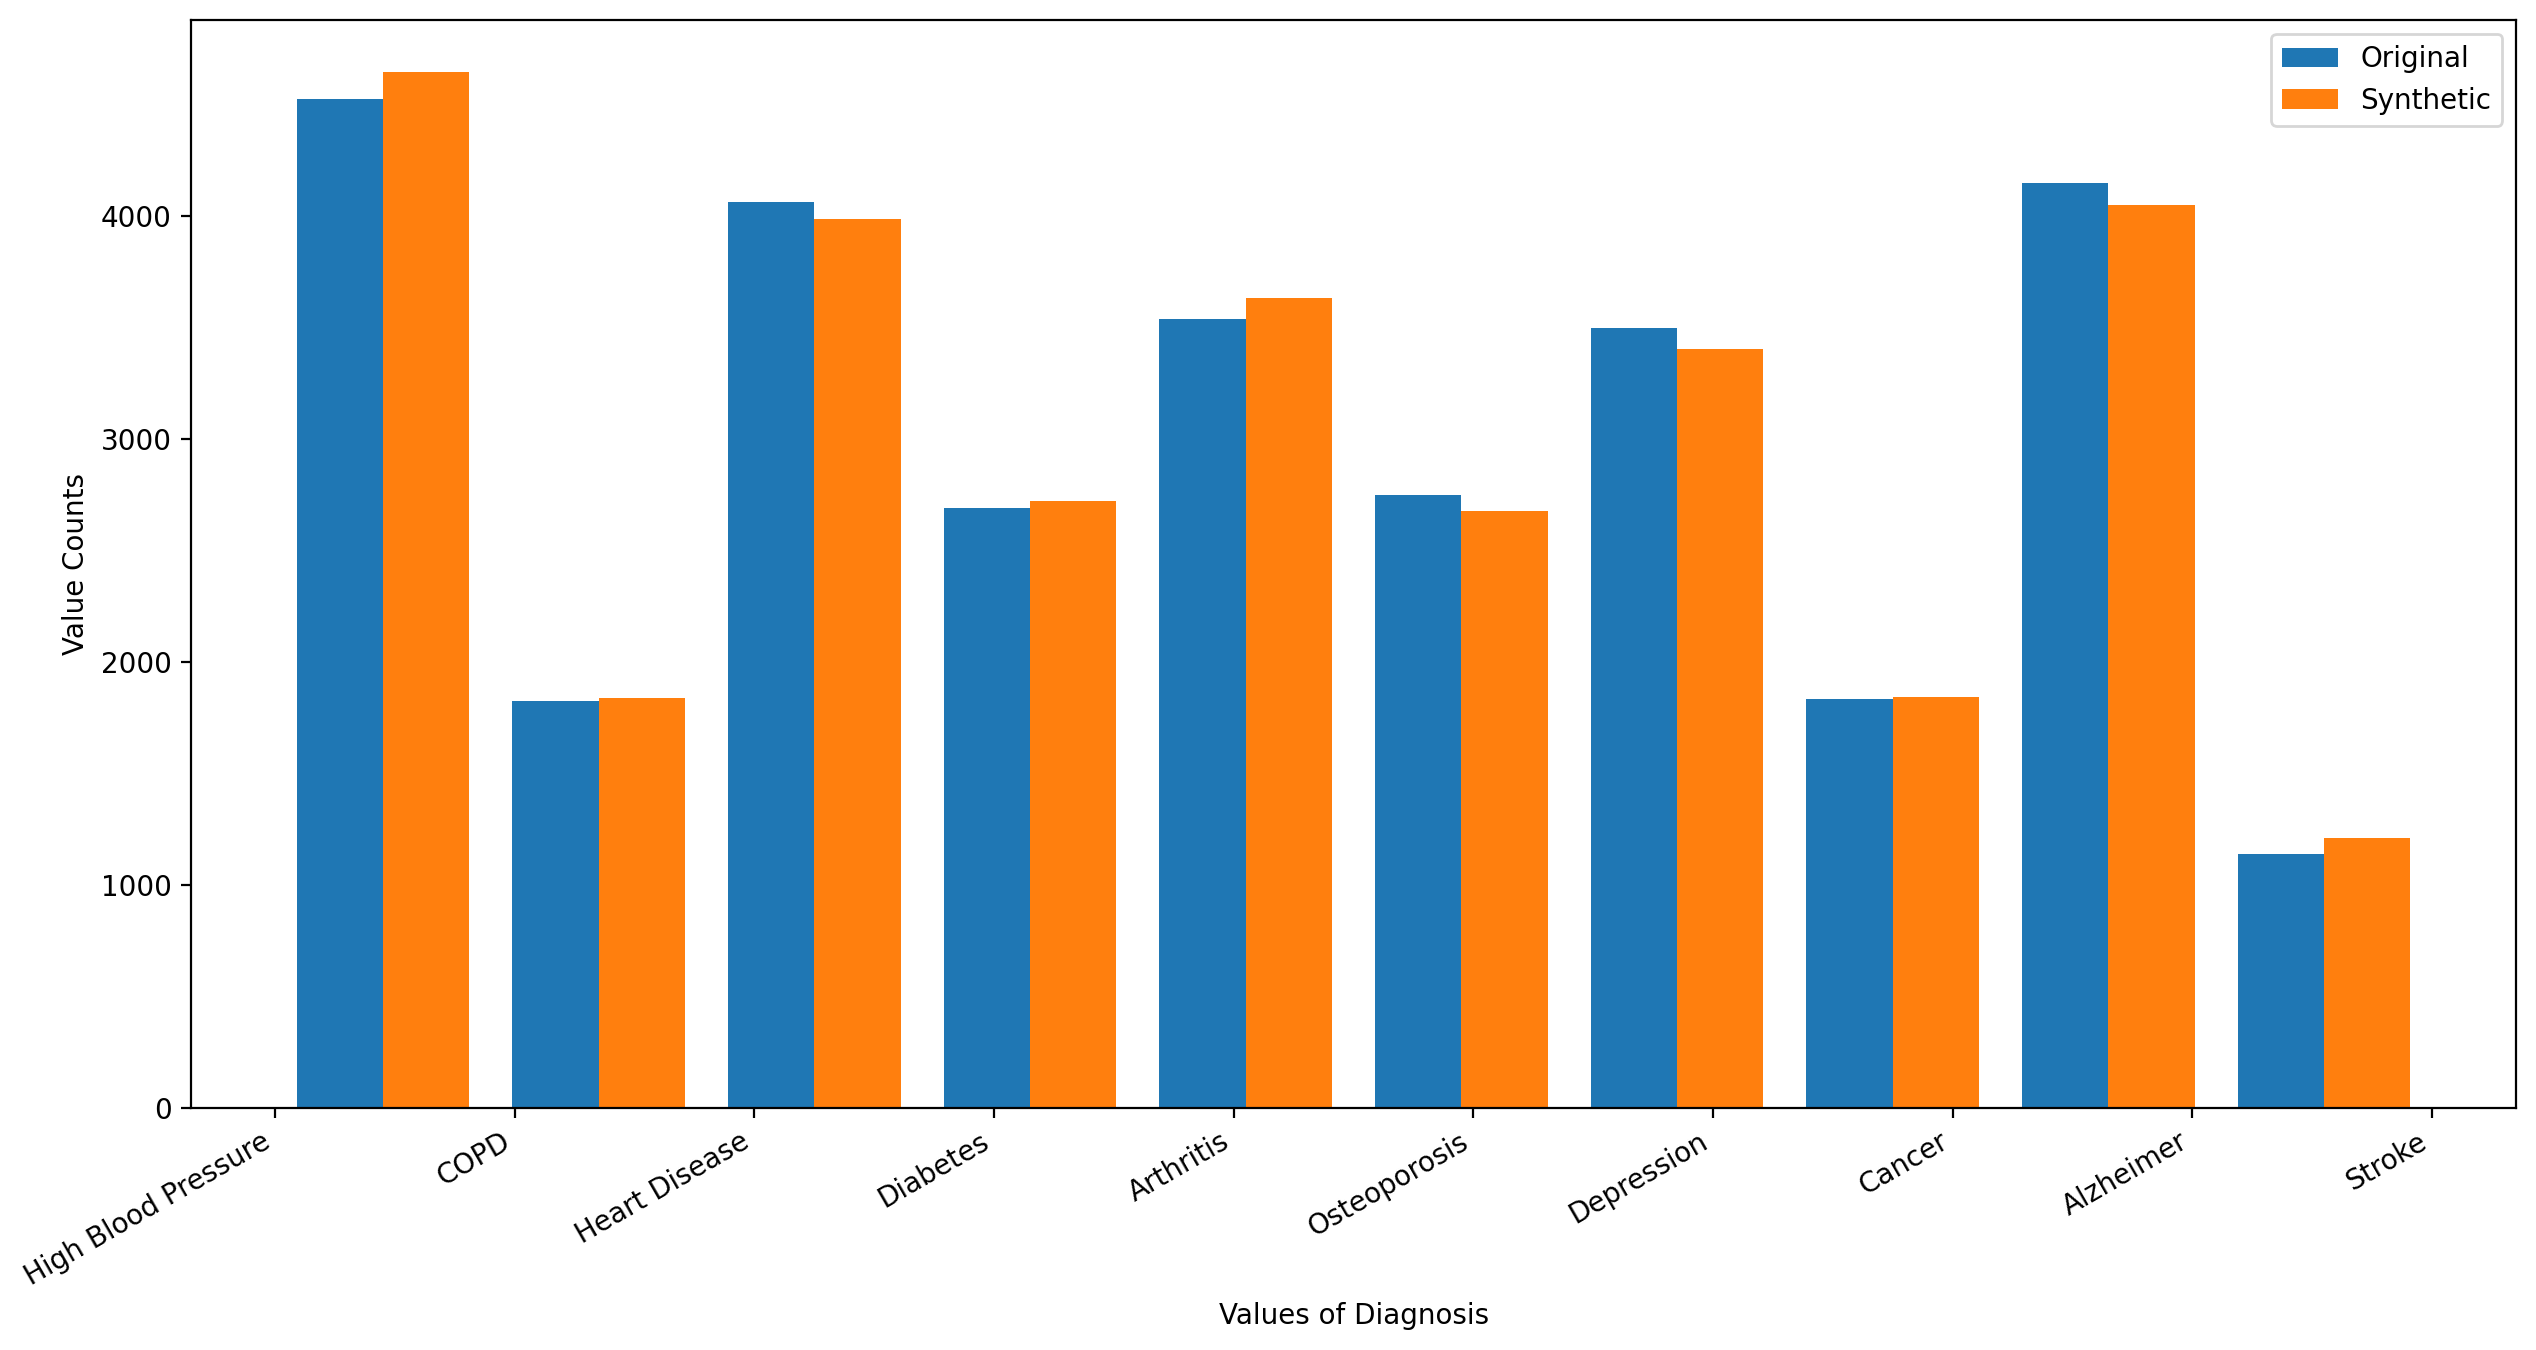

In [ ]:
reident.create_histogram(df_reident_encoded, df_synthesized, 'Diagnosis_encoded', reident.diseases)

In [ ]:
print('Medical Dataset:')
display(df_medical_synth.sample(5))
print('\nSynthesized Demographic Dataset:')
display(df_synthesized.sample(5))

Medical Dataset:


,ID,Gender,Age,Zip,Diagnosis,Treatment,Outcome
4222,d07f281fdce643918fe6408d7d8eea19,M,10,26876,Osteoporosis,26,recovered
26109,d21e74fcde3b4ebba7893c7815b31118,F,44,35937,Diabetes,33,recovered
21055,234cbf3c006845b8880293ad9924c84f,M,53,20246,Alzheimer,41,recovered
29054,0f2c3685b8e54ce4b77f2f15bf85a4ee,M,65,69421,Alzheimer,37,unchanged
8186,db30880c0da94130a197dd5c821af4e0,M,31,43137,High Blood Pressure,30,recovered



Synthesized Demographic Dataset:


,Gender_encoded,Age_encoded,Zip_encoded,Diagnosis_encoded
14884,1,11,15433,9
6599,0,65,23989,9
2564,1,47,45478,9
21303,0,87,23591,5
972,1,62,83284,7


### Perform the attack
Now, we perform the reidentification attack with the synthetic data, again using a combinatorial approach.

In [ ]:
reident_attack_2 = reident.try_reidentification_noise(df_synthesized, df_medical_synth, logger)

INFO:root:Trying reidentification with differential privacy-protected data: 30000. Attacker collection: 30000
INFO:root:In this setup, we can only count potential matches. We cannot validate for actual matches, as we do not have the unique patient ids after synthesizing.
100%|██████████| 30000/30000 [03:02<00:00, 164.15it/s]
INFO:root:Identified 0 potential matches!


### Results of the attack
Below, we show the amount of potential and actual matches and provide a glance at the data.

In [ ]:
print(f'Found {len(reident_attack_2)} potential matches!')
reident_attack_2.head()

Found 0 potential matches!


,ID,Gender,Age,Zip,Diagnosis,Treatment,Outcome
